In [2]:
%load_ext jupyter_black

## Table of Contents: <a class="anchor" id="toc"></a>
1. [Introduction](#introduction)
2. [Load Packages](#load_packages)
2. [Setting Environment Variables](#set_env_vars)
3. [Data Acquisition](#data_acquisition)
    1. [MP3 Downloader](#mp3_downloader)
4. [Exploratory Data Analysis](#eda)
    1. [Kaggle Dataset Exploration](#kaggle_eda)
    2. [Librosa Spectrograms](#librosa_eda)
5. [Vectorizing Data](#vectorizing_data)
6. [Pairwise Cosine Similarity](#pairwise_cosine_similarity)
7. [Creating Recommendation Playlist](#creating_playlist)
    1. [Flask App for Authorization](#flask_app)
    2. [Playlist Creation](#playlist_creation)
8. [Conclusion](#conclusion)

## Introduction <a class="anchor" id="introduction"></a>

The objective for Sprint 2 was to create an initial model using the data that was obtained and explored within Sprints 0 and 1, respectively. This notebook contains all of the relevant code of interest up to this point starting with the acquisition of the mp3 data and an exploration of the Kaggle dataset that helped obtain it. It ends with the creation of an array containing the pairwise cosine similarity for the tracks in the trianing dataset as well as a demonstration of an API call to create the playlist of similar tracks for the user.

[Back to Table of Contents](#toc)

## Load Packages <a class="anchor" id="load_packages"></a>

Packages relavant to th code are loaded below. Additionally, specific options or parameters are also set. For example, display options are set for `pandas` and the environment path to the environment variable file is provided for the `dotenv` package.

In [3]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import os
import sys
import pandas as pd
import numpy as np
import requests
from spotify_dl import spotify_dl
from pathlib import Path
import time
import os
from dotenv import load_dotenv  # changed magic command to explicit load
import librosa
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import pairwise
from typing import List
from flask import Flask, redirect, request

pd.set_option("display.max_rows", None)  # pandas dataframe formatting options
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.2f}".format


custom_env_path = "../../brainstation_capstone_cfg.env"  # environment variables file

In order to use the `spotify_dl` package to download the tracks that will comprise the dataset, a Spotify Web API app had to be created. From that app, the client ID and client secret were obtained and placed into the `brainstation_capstone_cfg.env` file. This file is then pulled into the present environment using the `python-dotenv` package via the magic command `%dotenv ../brainstation_capstone_cfg.env` above. The `spotify_dl` package also leverages another package known as `spotipy` and requires the `SPOTIPY_CLIENT_ID` and `SPOTIPY_CLIENT_SECRET` before it can begin downloading tracks. The credentials were stored within the external environment file which is not included within the repo for security reasons. In order to run this code, that information will be required. To obtain credentials please go to https://developer.spotify.com/documentation/web-api and follow the instructions under the 'Getting Started' section.

[Back to Table of Contents](#toc)

## Setting Environment Variables <a class="anchor" id="set_env_vars"></a>

In [4]:
# Spotify Developer Credentials
load_dotenv(dotenv_path=custom_env_path)
CLIENT_ID = os.environ.get("SPOTIPY_CLIENT_ID")
# client ID from app
CLIENT_SECRET = os.environ.get("SPOTIPY_CLIENT_SECRET")
# client secret from app
REDIRECT_URI = os.environ.get("REDIRECT_URI")
# redirect URI - the URI used here matches the one used within the app
SCOPE = "{} {}".format(os.environ.get("SCOPE_PUBLIC"), os.environ.get("SCOPE_PRIVATE"))
# formatted the scope this way to allow for custom configurations in the future
USERNAME = os.environ.get("SPOTIFY_USERNAME")
# Spotify username

[Back to Table of Contents](#toc)

## Data Acquisition <a class="anchor" id="data_acquisition"></a>

### MP3 Downloader <a class="anchor" id="mp3_downloader"></a>

The code below takes the track_ids that are extracted from the Kaggle data above and loops through them. It then concatenates these track_ids with the base_url to create a url that is fed into the spotify_dl package. This package then downloads the songs as .webm files which are then converted to .mp3 files using ffmpeg (which was installed separately using the conda install -c conda-forge ffmpeg command). With ffmpeg installed, the spotify_dl package utilizes it automatically. The .mp3 files are then saved to the mp3s folder within the data directory.

This code also contains a for loop before the while block that uses the os.walk function to check the mp3s directory for track_ids that have already been downloaded. I included this code since the process of downloading the sample needed to train the model needed required multiple days worth of runtime. Effectively, this code provides some measure of resume functionality to prevent overwriting existing files or needless iteration over tracks that have already been downloaded.

In [5]:
file_path = "/Users/vii/repos/brainstation_capstone/data/mp3s/"
base_url = "https://open.spotify.com/track/"
track_dirs = []
dirs = []
files = []
for root, dir, file in os.walk(file_path):
    dirs.append(dir)
    files.append(file)
    if len(dirs) > 0:
        track_dirs = dirs[0].copy()
len(track_dirs)

11923

In [6]:
mp3s = [mp3[0] for mp3 in files if len(mp3) > 0 and "mp3" in mp3[0]]

In [7]:
len(mp3s)

11575

Output from code cell below looks like this:
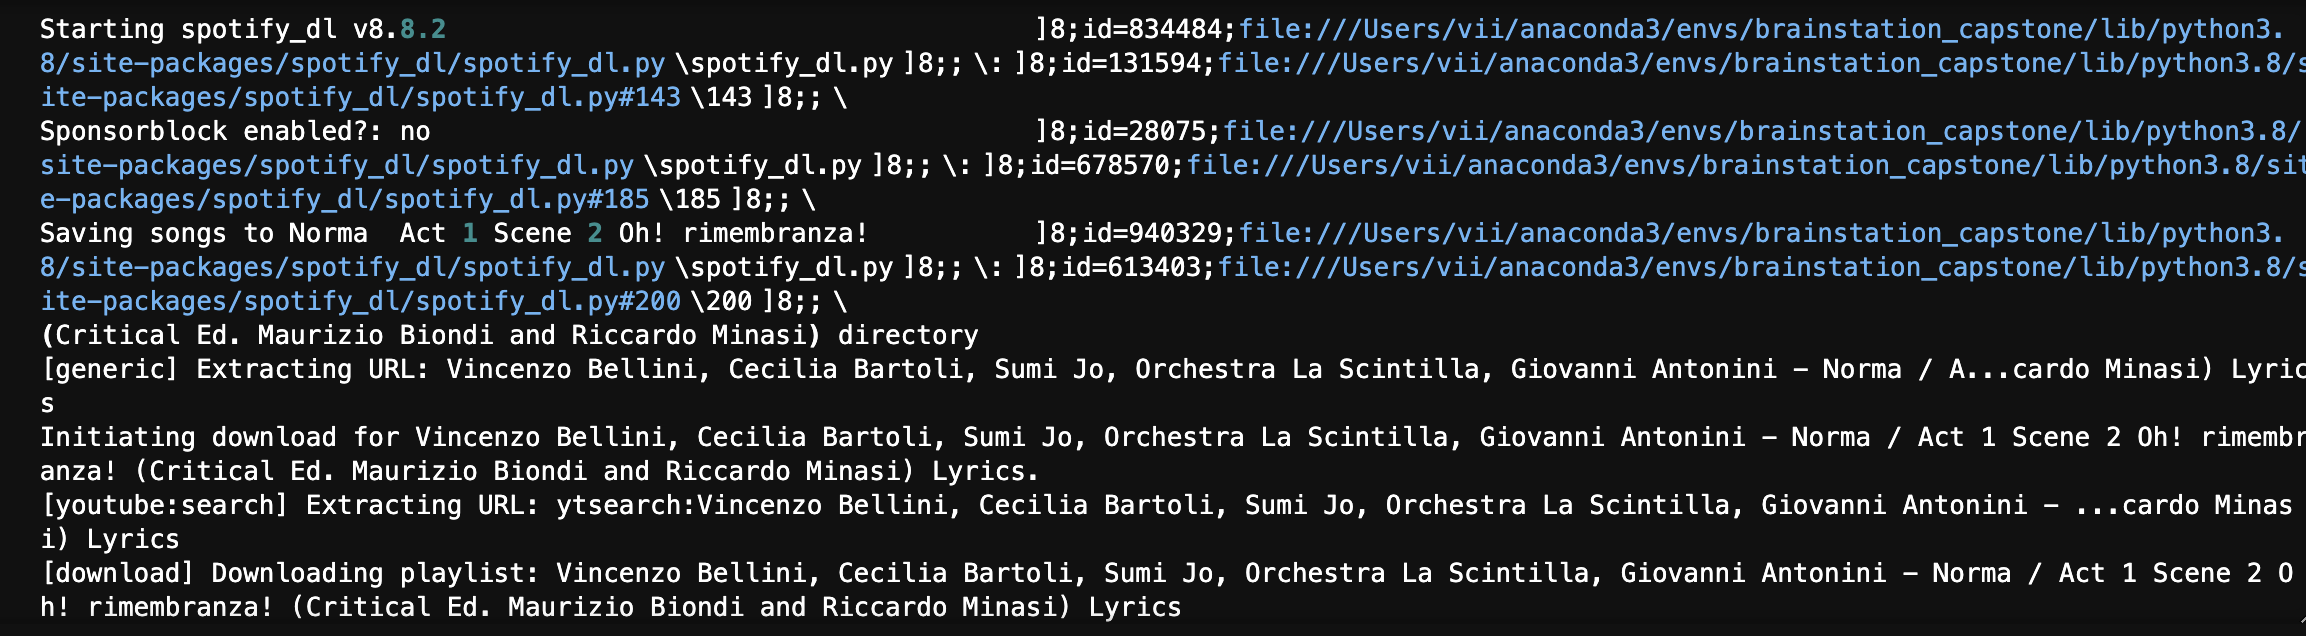

In [8]:
kaggle_df = pd.read_csv("../data/SpotifyFeatures.csv")
track_ids = (
    kaggle_df.sample(30000, random_state=123).track_id.str.strip().unique().tolist()
)
len(track_ids)

28622

In [9]:
# Commented out since running this is not necessary for displaying the notebook.
# os.system("export SPOTIPY_CLIENT_ID={}".format(CLIENT_ID))
# os.system('export SPOTIPY_CLIENT_SECRET={}'.format(CLIENT_SECRET))
# count = 0
# while count<12000:
#     for track_id in track_ids:
#         if (len(track_dirs)>0) & (track_id in track_dirs):
#             count+=1
#             print(f'{count}: {track_id} already downloaded...skipping....')
#         else:
#             url = base_url+track_id
#             os.system("spotify_dl --url {} -o ../data/mp3s/{}".format(url,track_id))
#             count+=1
#             time.sleep(10) # 10 second delay between requests

[Back to Table of Contents](#toc)

## Exploratory Data Analysis (EDA) <a class="anchor" id="eda"></a>

### Kaggle Dataset Exploration <a class="anchor" id="kaggle_eda"></a>

The dataset from Kaggle is read in below. The data contains 232,725 rows which is comprised of 176,774 unique track_ids. A random sample of 30,000 rows is extracted below. From these 28,622 unique track_ids are present. The unique track_ids are stripped of trailing and leading spaces before being put into a list for looping. This list of track IDs was also useful for creating playlists within Spotify to gauge The EDA performed on this dataset is presented below.

In [10]:
kaggle_df.head()

genre        artist_name                        track_name  \
0  Movie     Henri Salvador       C'est beau de faire un Show   
1  Movie  Martin & les fées  Perdu d'avance (par Gad Elmaleh)   
2  Movie    Joseph Williams    Don't Let Me Be Lonely Tonight   
3  Movie     Henri Salvador    Dis-moi Monsieur Gordon Cooper   
4  Movie       Fabien Nataf                         Ouverture   

                 track_id  popularity  acousticness  danceability  \
0  0BRjO6ga9RKCKjfDqeFgWV           0          0.61          0.39   
1  0BjC1NfoEOOusryehmNudP           1          0.25          0.59   
2  0CoSDzoNIKCRs124s9uTVy           3          0.95          0.66   
3  0Gc6TVm52BwZD07Ki6tIvf           0          0.70          0.24   
4  0IuslXpMROHdEPvSl1fTQK           4          0.95          0.33   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0        99373    0.91              0.00  C#      0.35     -1.83  Major   
1       137373    0.74              0.00  F#      0.15     -5.56  Minor   
2       170267    0.13              0.00   C      0.10    -13.88  Minor   
3       152427    0.33              0.00  C#      0.10    -12.18  Major   
4        82625    0.23              0.12   F      0.20    -21.15  Major   

   speechiness  tempo time_signature  valence  
0         0.05 166.97          4-Apr     0.81  
1         0.09 174.00          4-Apr     0.82  
2         0.04  99.49          4-May     0.37  
3         0.04 171.76          4-Apr     0.23  
4         0.05 140.58          4-Apr     0.39

Conveniently, all of the columns are lowercase and have had their space characters replaced by _ characters. The info function also reveals that there are no nulls in the dataframe either as the number of non-null values is equal to the row count for the dataframe.

In [11]:
kaggle_df.shape

(232725, 18)

In [12]:
kaggle_df.columns

Index(['genre', 'artist_name', 'track_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')

In [13]:
kaggle_df.info()
# There are no nulls within the Kaggle dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232725 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

In [14]:
kaggle_df.genre.value_counts(
    normalize=True
) * 100  # relatively good balance between genres

Comedy             4.16
Soundtrack         4.14
Indie              4.10
Jazz               4.06
Pop                4.03
Electronic         4.03
Children’s Music   4.02
Folk               4.00
Hip-Hop            3.99
Rock               3.98
Alternative        3.98
Classical          3.98
Rap                3.97
World              3.91
Soul               3.91
Blues              3.88
R&B                3.86
Anime              3.84
Reggaeton          3.84
Ska                3.81
Reggae             3.77
Dance              3.74
Country            3.72
Opera              3.56
Movie              3.35
Children's Music   2.32
A Capella          0.05
Name: genre, dtype: float64

Text(0.5, 1.0, 'Distribution of Genres in Kaggle Dataset')

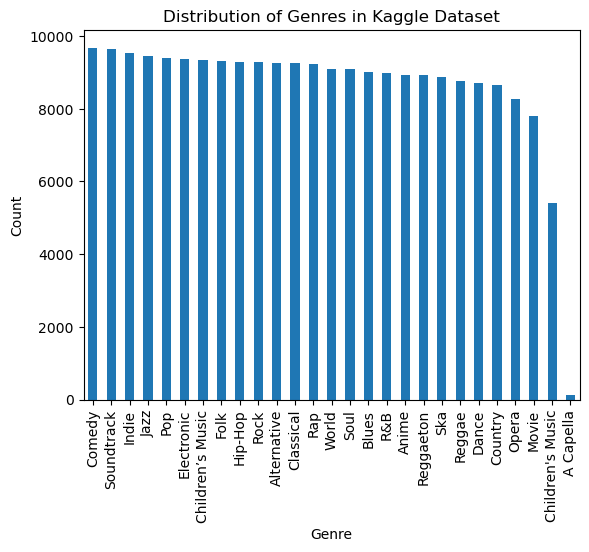

In [15]:
# Genre Distribution
plt.figure()
kaggle_df.genre.value_counts().plot(kind="bar")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("Distribution of Genres in Kaggle Dataset")

In [16]:
kaggle_df.duration_ms.value_counts(
    bins=20
)  # most songs are of a short duration, but there are some clear outliers that are much longer

(9849.469, 292263.5]      193597
(292263.5, 569140.0]       36288
(569140.0, 846016.5]        2099
(846016.5, 1122893.0]        404
(1122893.0, 1399769.5]       150
(1399769.5, 1676646.0]        56
(1676646.0, 1953522.5]        24
(2230399.0, 2507275.5]        21
(3061028.5, 3337905.0]        14
(3337905.0, 3614781.5]        12
(2784152.0, 3061028.5]        12
(2507275.5, 2784152.0]        12
(1953522.5, 2230399.0]        12
(3614781.5, 3891658.0]         9
(4722287.5, 4999164.0]         4
(3891658.0, 4168534.5]         3
(4168534.5, 4445411.0]         3
(4445411.0, 4722287.5]         3
(5276040.5, 5552917.0]         2
(4999164.0, 5276040.5]         0
Name: duration_ms, dtype: int64

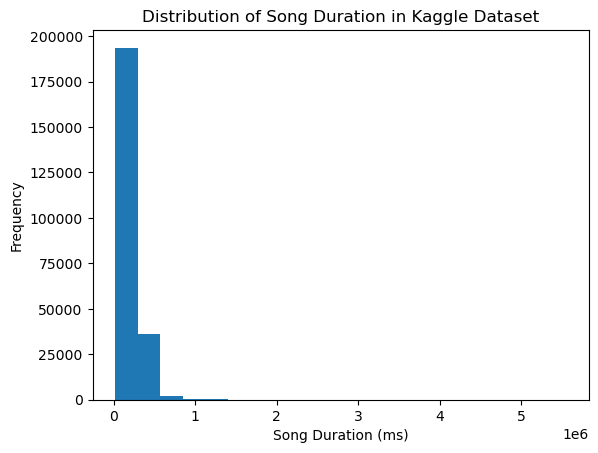

In [17]:
plt.figure()
kaggle_df.duration_ms.plot(kind="hist", bins=20)
plt.xlabel("Song Duration (ms)")
plt.title("Distribution of Song Duration in Kaggle Dataset")
plt.show()

In [18]:
kaggle_df.track_id.nunique()  # there are fewer track ids than there are rows

176774

In [19]:
kaggle_df.track_id.value_counts(
    ascending=False
).head()  # some of the track_ids appear more than once
# This seemed odd considering that the track_id should be a unique identifier.

3R73Y7X53MIQZWnKloWq5i    8
0wY9rA9fJkuESyYm9uzVK5    8
6sVQNUvcVFTXvlk3ec0ngd    8
0UE0RhnRaEYsiYgXpyLoZc    8
6AIte2Iej1QKlaofpjCzW1    8
Name: track_id, dtype: int64

In [20]:
kaggle_df.loc[kaggle_df.track_id == "3R73Y7X53MIQZWnKloWq5i"]
# This shows that a single track id does correspond to a single song, but that the song can repeat within the data set
# based on the genre. All of the other columns are the same though.

genre artist_name               track_name  \
5506         Alternative  Toro y Moi  Monte Carlo (feat. WET)   
15615              Dance  Toro y Moi  Monte Carlo (feat. WET)   
41367               Folk  Toro y Moi  Monte Carlo (feat. WET)   
55106                R&B  Toro y Moi  Monte Carlo (feat. WET)   
77769   Children’s Music  Toro y Moi  Monte Carlo (feat. WET)   
94721              Indie  Toro y Moi  Monte Carlo (feat. WET)   
149585               Pop  Toro y Moi  Monte Carlo (feat. WET)   
225238              Rock  Toro y Moi  Monte Carlo (feat. WET)   

                      track_id  popularity  acousticness  danceability  \
5506    3R73Y7X53MIQZWnKloWq5i          50          0.08          0.65   
15615   3R73Y7X53MIQZWnKloWq5i          61          0.08          0.65   
41367   3R73Y7X53MIQZWnKloWq5i          61          0.08          0.65   
55106   3R73Y7X53MIQZWnKloWq5i          61          0.08          0.65   
77769   3R73Y7X53MIQZWnKloWq5i          61          0.08          0.65   
94721   3R73Y7X53MIQZWnKloWq5i          61          0.08          0.65   
149585  3R73Y7X53MIQZWnKloWq5i          61          0.08          0.65   
225238  3R73Y7X53MIQZWnKloWq5i          61          0.08          0.65   

        duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
5506         125133    0.38              0.00  C#      0.17     -8.97  Major   
15615        125133    0.38              0.00  C#      0.17     -8.97  Major   
41367        125133    0.38              0.00  C#      0.17     -8.97  Major   
55106        125133    0.38              0.00  C#      0.17     -8.97  Major   
77769        125133    0.38              0.00  C#      0.17     -8.97  Major   
94721        125133    0.38              0.00  C#      0.17     -8.97  Major   
149585       125133    0.38              0.00  C#      0.17     -8.97  Major   
225238       125133    0.38              0.00  C#      0.17     -8.97  Major   

        speechiness  tempo time_signature  valence  
5506           0.05 140.08          4-Apr     0.13  
15615          0.05 140.08          4-Apr     0.13  
41367          0.05 140.08          4-Apr     0.13  
55106          0.05 140.08          4-Apr     0.13  
77769          0.05 140.08          4-Apr     0.13  
94721          0.05 140.08          4-Apr     0.13  
149585         0.05 140.08          4-Apr     0.13  
225238         0.05 140.08          4-Apr     0.13

In [21]:
kaggle_df.loc[kaggle_df.track_id == "2qtoRFCOEL1gRn5q9DJC7F"]

genre  artist_name      track_name                track_id  \
3042         Alternative  Frank Ocean  Solo (Reprise)  2qtoRFCOEL1gRn5q9DJC7F   
55038                R&B  Frank Ocean  Solo (Reprise)  2qtoRFCOEL1gRn5q9DJC7F   
69075            Hip-Hop  Frank Ocean  Solo (Reprise)  2qtoRFCOEL1gRn5q9DJC7F   
78415   Children’s Music  Frank Ocean  Solo (Reprise)  2qtoRFCOEL1gRn5q9DJC7F   
116591               Rap  Frank Ocean  Solo (Reprise)  2qtoRFCOEL1gRn5q9DJC7F   
149496               Pop  Frank Ocean  Solo (Reprise)  2qtoRFCOEL1gRn5q9DJC7F   
192514              Soul  Frank Ocean  Solo (Reprise)  2qtoRFCOEL1gRn5q9DJC7F   

        popularity  acousticness  danceability  duration_ms  energy  \
3042            58          0.40          0.54        78743    0.75   
55038           63          0.40          0.54        78743    0.75   
69075           63          0.40          0.54        78743    0.75   
78415           62          0.40          0.54        78743    0.75   
116591          63          0.40          0.54        78743    0.75   
149496          63          0.40          0.54        78743    0.75   
192514          63          0.40          0.54        78743    0.75   

        instrumentalness key  liveness  loudness   mode  speechiness  tempo  \
3042                0.00   G      0.09     -6.81  Minor         0.16  83.29   
55038               0.00   G      0.09     -6.81  Minor         0.16  83.29   
69075               0.00   G      0.09     -6.81  Minor         0.16  83.29   
78415               0.00   G      0.09     -6.81  Minor         0.16  83.29   
116591              0.00   G      0.09     -6.81  Minor         0.16  83.29   
149496              0.00   G      0.09     -6.81  Minor         0.16  83.29   
192514              0.00   G      0.09     -6.81  Minor         0.16  83.29   

       time_signature  valence  
3042            4-Apr     0.60  
55038           4-Apr     0.60  
69075           4-Apr     0.60  
78415           4-Apr     0.60  
116591          4-Apr     0.60  
149496          4-Apr     0.60  
192514          4-Apr     0.60

It seems that the track_id is a unique identifier, but there are tracks that are duplicated across genre. This could be a biproduct of how the data was originally obtained.

In [22]:
kaggle_df.loc[kaggle_df.popularity > 20].sort_values(
    by="popularity", ascending=False
).shape[0] / kaggle_df.shape[0] * 100
# roughly 86% of the dataset is above a popularity score of 20
# this means that ~14% is below 20

86.06080137501343

In [69]:
kaggle_df.loc[kaggle_df.track_name.str.lower().str.contains("take on me")]

genre    artist_name  \
3096         Alternative         Weezer   
13631              Dance           a-ha   
17473              Dance           a-ha   
19917              Dance           a-ha   
77365   Children’s Music         Weezer   
108853               Pop           a-ha   
110186               Pop         Weezer   
151905               Pop           a-ha   
155216              Rock  Reel Big Fish   
156518               Ska  Reel Big Fish   
166140              Rock           a-ha   
166469              Rock         Weezer   
185722               Ska  Reel Big Fish   
186904               Ska  Reel Big Fish   
187182               Ska           MxPx   
189238               Ska  Reel Big Fish   
224607              Rock           a-ha   

                                     track_name                track_id  \
3096                                 Take On Me  1ZB2qWsheGabSEYvBYxjKn   
13631                                Take on Me  2WfaOiMkCvy7F5fcp2zZ8L   
17473                                Take On Me  6Id7qFA0mNC4VCkQbG1PyZ   
19917                   Take On Me - Kygo Remix  5UHuuQGEgMbZrYnHjQG9ny   
77365                                Take On Me  1ZB2qWsheGabSEYvBYxjKn   
108853                               Take on Me  2WfaOiMkCvy7F5fcp2zZ8L   
110186                               Take On Me  1ZB2qWsheGabSEYvBYxjKn   
151905               Take On Me - MTV Unplugged  7htt7UuxHL5wneOcMWJP5E   
155216                               Take On Me  7IfckgnBsIdP4XE4tfWEDN   
156518                               Take On Me  7IfckgnBsIdP4XE4tfWEDN   
166140                               Take on Me  2WfaOiMkCvy7F5fcp2zZ8L   
166469                               Take On Me  1ZB2qWsheGabSEYvBYxjKn   
185722                Take On Me - (Skacoustic)  5kFRQ3PXkKD62Laslvg05E   
186904                        Take On Me - Live  6jfYROuhDw7HtOGGRclpEX   
187182  Take On Me - On The Cover Album Version  1XhghkUto8Nin87Vquu8Ep   
189238                     Take On Me - Best Of  57ymizHvhrdhddyrcphqyn   
224607               Take On Me - MTV Unplugged  7htt7UuxHL5wneOcMWJP5E   

        popularity  acousticness  danceability  duration_ms  energy  \
3096            59          0.01          0.44       223560    0.76   
13631           84          0.02          0.57       225280    0.90   
17473            0          0.01          0.53       228520    0.93   
19917           58          0.16          0.54       226667    0.78   
77365           70          0.01          0.44       223560    0.76   
108853          84          0.02          0.57       225280    0.90   
110186          70          0.01          0.44       223560    0.76   
151905          65          0.96          0.47       253907    0.20   
155216          60          0.02          0.58       199253    0.94   
156518          60          0.02          0.58       199253    0.94   
166140          84          0.02          0.57       225280    0.90   
166469          70          0.01          0.44       223560    0.76   
185722          30          0.12          0.64       196747    0.82   
186904          25          0.02          0.49       207693    0.94   
187182          27          0.00          0.37       216307    0.85   
189238          21          0.02          0.39       198884    0.94   
224607          65          0.96          0.47       253907    0.20   

        instrumentalness key  liveness  loudness   mode  speechiness  tempo  \
3096                0.00  G#      0.09     -3.86  Major         0.04 167.96   
13631               0.00  F#      0.09     -7.64  Minor         0.05  84.41   
17473               0.00  F#      0.05     -6.44  Minor         0.05 169.42   
19917               0.00   A      0.14     -6.01  Major         0.11 179.96   
77365               0.00  G#      0.09     -3.86  Major         0.04 167.96   
108853              0.00  F#      0.09     -7.64  Minor         0.05  84.41   
110186              0.00  G#      0.09     -3.86  Major      

[Back to Table of Contents](#toc)

### Librosa Spectrograms <a class="anchor" id="librosa_eda"></a>

The `librosa` package meaasures specific spectra from audio signals. The output is a vectorized signal that can then be used within a model. Below the three functions are taken from this tutorial on training a classification model using Keras from the following link:

https://blog.paperspace.com/music-genre-classification-using-librosa-and-pytorch/

Two examples are shown below. The first is "Take On Me" by Weezer and the second is "Rigoletto  Act 2 Cortigiani, vil razza dannata...Ebben piango" as performed by the London Syphony Orchestra. These tracks were selected at random from the dataset. For each track, four spectra are depicted. The information for each spectra along with a brief description and the references for each are listed below:

* Mel Spectrogram
    * Loudness profile
    * https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53
    * https://librosa.org/doc/latest/generated/librosa.feature.melspectrogram.html
* Chroma Vector
    * Pitch-class profile
    * https://en.wikipedia.org/wiki/Chroma_feature
    * https://librosa.org/doc/latest/generated/librosa.feature.chroma_stft.html
* Tonnal Centroid Features (Tonnetz) Spectrum
    * Harmonic relationships
    * https://en.wikipedia.org/wiki/Tonnetz
    * https://librosa.org/doc/latest/generated/librosa.feature.tonnetz.html
* Mel Frequency Cepstral Coefficients
    * Power spectrum coefficients (energy density of sound)
    * https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

NOTE: All of these links are also available within the README for this project.

In [55]:
# May need to update the sr to just be none so that you can use the native sampling frequency
# this would increase the processing time initially, but it would also improve the quality of the signal data
def get_mfcc(wav_file_path):
    y, sr = librosa.load(wav_file_path, offset=10, duration=60)
    # it appears that the load function loads 
    mfcc = np.array(librosa.feature.mfcc(y=y, sr=sr))
    return mfcc


def get_melspectrogram(wav_file_path):
    y, sr = librosa.load(wav_file_path, offset=10, duration=60)
    melspectrogram = np.array(librosa.feature.melspectrogram(y=y, sr=sr))
    # this is a power spectrum (amplitude squared)
    return melspectrogram


def get_chroma_vector(wav_file_path):
    y, sr = librosa.load(wav_file_path) # pass offset and duration here
    chroma = np.array(librosa.feature.chroma_stft(y=y, sr=sr))
    return chroma


def get_tonnetz(wav_file_path):
    y, sr = librosa.load(wav_file_path)
    tonnetz = np.array(librosa.feature.tonnetz(y=y, sr=sr))
    return tonnetz


def get_feature(file_path):
    # Extracting MFCC feature
    mfcc = get_mfcc(file_path)
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_min = mfcc.min(axis=1)
    mfcc_max = mfcc.max(axis=1)
    mfcc_feature = np.concatenate((mfcc_mean, mfcc_min, mfcc_max))

    # Extracting Mel Spectrogram feature
    melspectrogram = get_melspectrogram(file_path)
    melspectrogram_mean = melspectrogram.mean(axis=1)
    melspectrogram_min = melspectrogram.min(axis=1)
    melspectrogram_max = melspectrogram.max(axis=1)
    melspectrogram_feature = np.concatenate(
        (melspectrogram_mean, melspectrogram_min, melspectrogram_max)
    )

    # Extracting chroma vector feature
    chroma = get_chroma_vector(file_path)
    chroma_mean = chroma.mean(axis=1)
    chroma_min = chroma.min(axis=1)
    chroma_max = chroma.max(axis=1)
    chroma_feature = np.concatenate((chroma_mean, chroma_min, chroma_max))

    # Extracting tonnetz feature
    tntz = get_tonnetz(file_path)
    tntz_mean = tntz.mean(axis=1)
    tntz_min = tntz.min(axis=1)
    tntz_max = tntz.max(axis=1)
    tntz_feature = np.concatenate((tntz_mean, tntz_min, tntz_max))

    feature = np.concatenate(
        (chroma_feature, melspectrogram_feature, mfcc_feature, tntz_feature)
    )
    return feature

In [56]:
example_file = "/Users/vii/repos/brainstation_capstone/data/mp3s/1ZB2qWsheGabSEYvBYxjKn/Take on Me/Weezer - Take on Me.mp3"

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


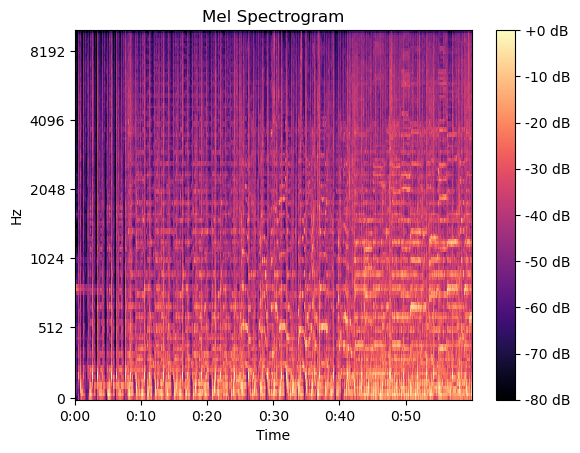

<class 'numpy.ndarray'>


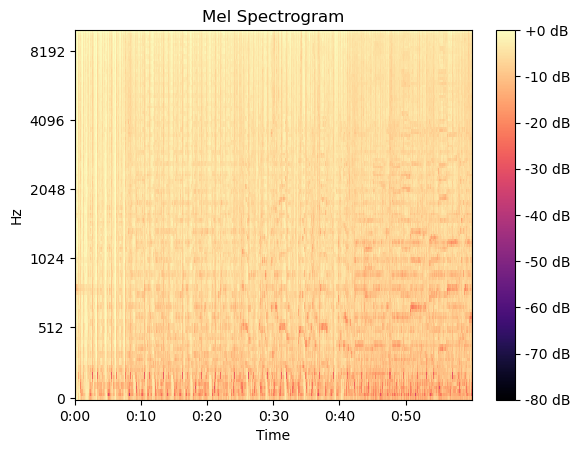

In [73]:
# Melodic Profile (divides sounds up based on human hearing)
# https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53
# https://librosa.org/doc/latest/generated/librosa.feature.melspectrogram.html
melspectrogram = get_melspectrogram(example_file)
print(type(melspectrogram))
melspectrogram = librosa.power_to_db(melspectrogram, ref=np.max)
print(type(melspectrogram))
# power_to_db takes in np.array
plt.figure()
librosa.display.specshow(melspectrogram, y_axis="mel", fmax=10000, x_axis="time")
plt.title("Mel Spectrogram")
plt.colorbar(format="%+2.0f dB")
plt.show()
# plt.imshow(melspectrogram, interpolation='nearest', aspect='auto')
# plt.title('Mel Spectrogram - Take on Me by Weezer')
# plt.show()
plt.figure()
melspectrogram = librosa.amplitude_to_db(melspectrogram, ref=np.max)
print(type(melspectrogram))
# power_to_db takes in np.array
librosa.display.specshow(melspectrogram, y_axis="mel", fmax=10000, x_axis="time")
plt.title("Mel Spectrogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

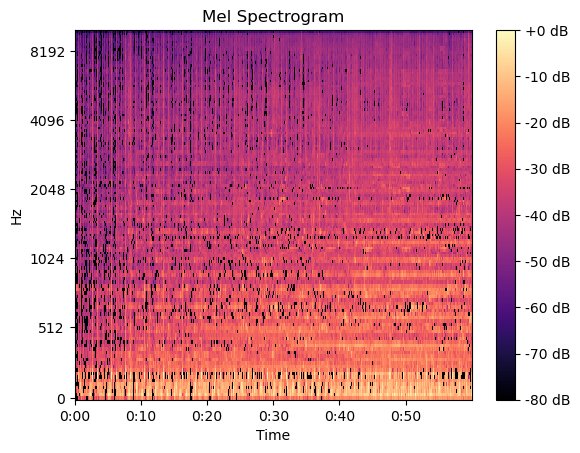

In [58]:
melspectrogram = get_melspectrogram(example_file)
data_h, data_p = librosa.effects.hpss(melspectrogram)
data_h = librosa.power_to_db(data_h, ref=np.max)
librosa.display.specshow(data_h, y_axis="mel", fmax=10000, x_axis="time")
plt.title("Mel Spectrogram")
plt.colorbar(format="%+2.0f dB");

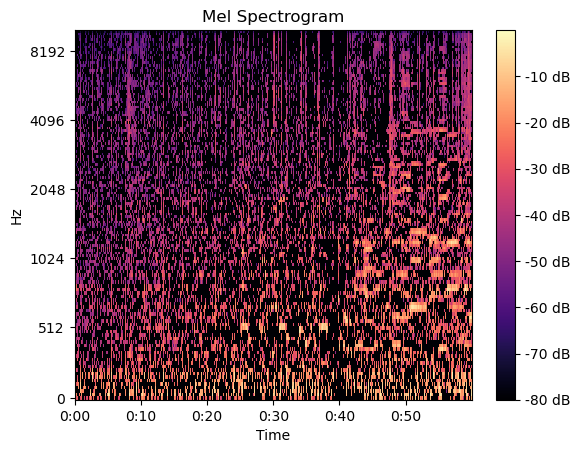

In [59]:
data_p = librosa.power_to_db(data_p, ref=np.max)
librosa.display.specshow(data_p, y_axis="mel", fmax=10000, x_axis="time")
plt.title("Mel Spectrogram")
plt.colorbar(format="%+2.0f dB");

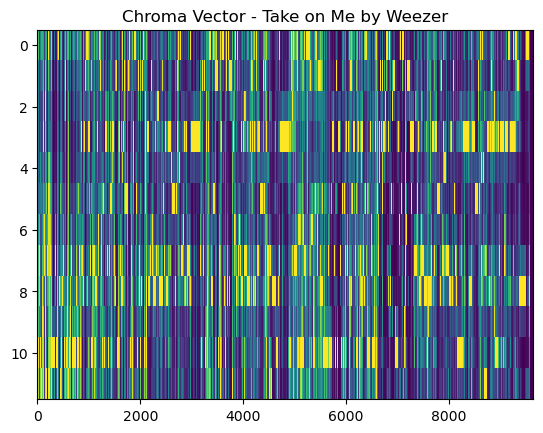

In [60]:
# Pitch-class profile
# https://en.wikipedia.org/wiki/Chroma_feature
# https://librosa.org/doc/latest/generated/librosa.feature.chroma_stft.html
chroma = get_chroma_vector(example_file)
plt.imshow(chroma, interpolation="nearest", aspect="auto")
plt.title("Chroma Vector - Take on Me by Weezer")
plt.show()

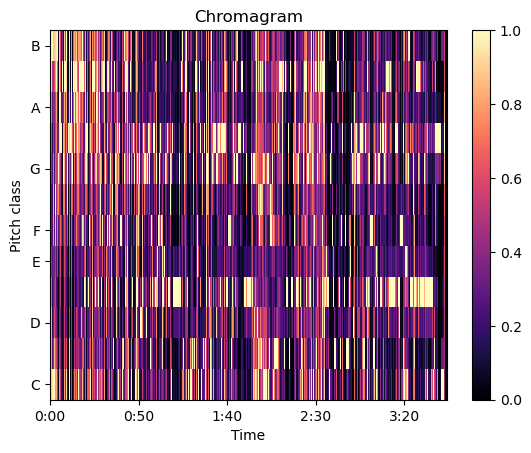

In [71]:
chroma = get_chroma_vector(example_file)
librosa.display.specshow(
    chroma, y_axis="chroma", fmax=10000, x_axis="time", vmin=0, vmax=1
)
# plt.title("Chroma Spectrogram")
# plt.colorbar(format="%+2.0f dB");

plt.title("Chromagram")
plt.colorbar()
plt.show()

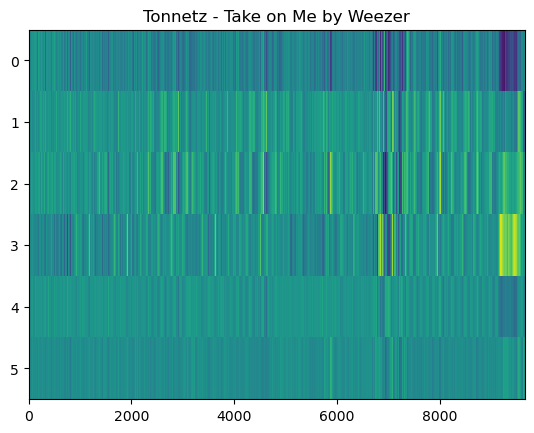

In [118]:
# Harmonic Relationships (Tonnetz)
# https://en.wikipedia.org/wiki/Tonnetz
# https://librosa.org/doc/latest/generated/librosa.feature.tonnetz.html
tntz = get_tonnetz(example_file)
plt.imshow(tntz , interpolation='nearest', aspect='auto')
plt.title('Tonnetz - Take on Me by Weezer')
plt.show()

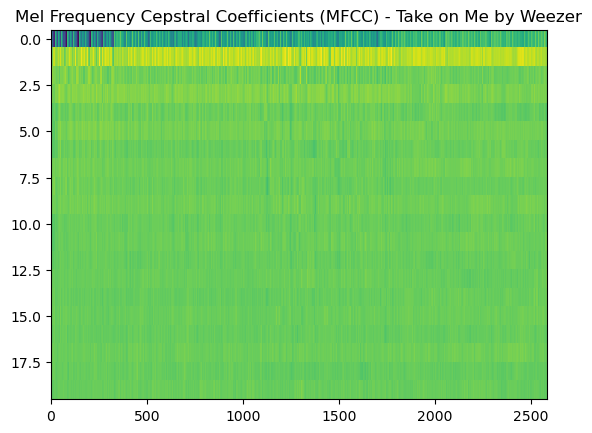

In [119]:
# Power Spectrum (Energy Density) Coefficients as plotted on Mel Scale
# https://en.wikipedia.org/wiki/Mel-frequency_cepstrum
mfcc = get_mfcc(example_file)
plt.imshow(mfcc , interpolation='nearest', aspect='auto')
plt.title('Mel Frequency Cepstral Coefficients (MFCC) - Take on Me by Weezer')
plt.show()

In [91]:
example_file = "/Users/vii/repos/brainstation_capstone/data/mp3s/1cjvpB46mcjPIt9KFktKwk/Rigoletto  Act 2 Cortigiani, vil razza dannata...Ebben piango/Giuseppe Verdi, Sherrill Milnes, London Symphony Orchestra, Richard Bonynge - #Rigoletto # Act 2# ##Cortigiani, vil razza dannata...Ebben piango###.mp3"

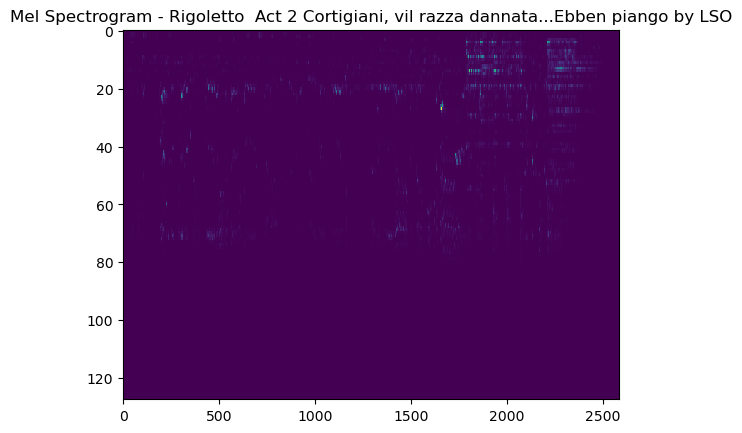

In [38]:
melspectrogram = get_melspectrogram(example_file)
plt.imshow(melspectrogram, interpolation="nearest", aspect="auto")
plt.title(
    "Mel Spectrogram - Rigoletto  Act 2 Cortigiani, vil razza dannata...Ebben piango by LSO"
)
plt.show()

In [92]:
melspectrogram = get_melspectrogram(example_file)
melspectrogram.shape

(128, 2584)

In [ ]:
print(type(melspectrogram))
melspectrogram = librosa.power_to_db(melspectrogram, ref=np.max)
print(type(melspectrogram))
# power_to_db takes in np.array
librosa.display.specshow(melspectrogram, y_axis="mel", fmax=10000, x_axis="time")
plt.title("Mel Spectrogram")
plt.colorbar(format="%+2.0f dB");

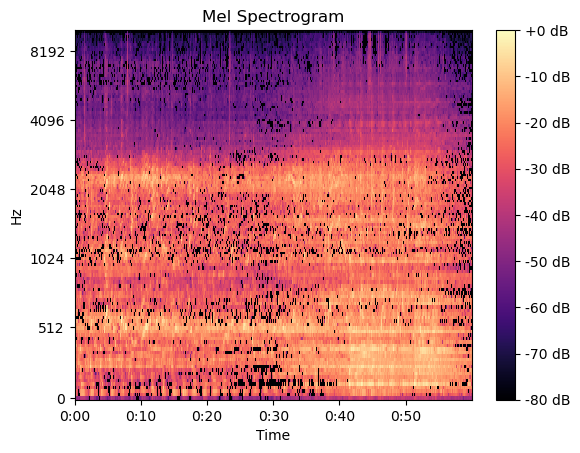

In [40]:
melspectrogram = get_melspectrogram(example_file)
data_h, data_p = librosa.effects.hpss(melspectrogram)
data_h = librosa.power_to_db(data_h, ref=np.max)
librosa.display.specshow(data_h, y_axis="mel", fmax=10000, x_axis="time")
plt.title("Mel Spectrogram")
plt.colorbar(format="%+2.0f dB");

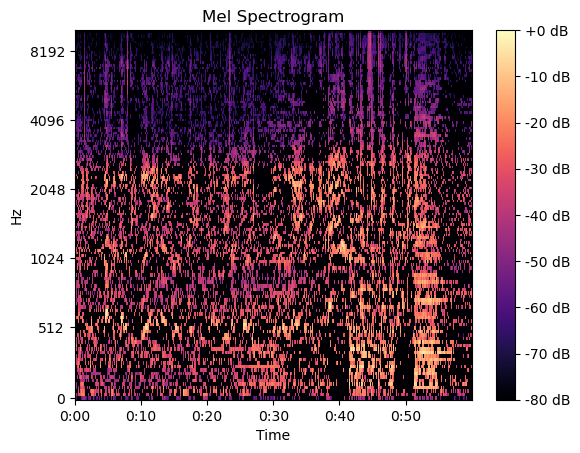

In [41]:
data_p = librosa.power_to_db(data_p, ref=np.max)
librosa.display.specshow(data_p, y_axis="mel", fmax=10000, x_axis="time")
plt.title("Mel Spectrogram ")
plt.colorbar(format="%+2.0f dB");

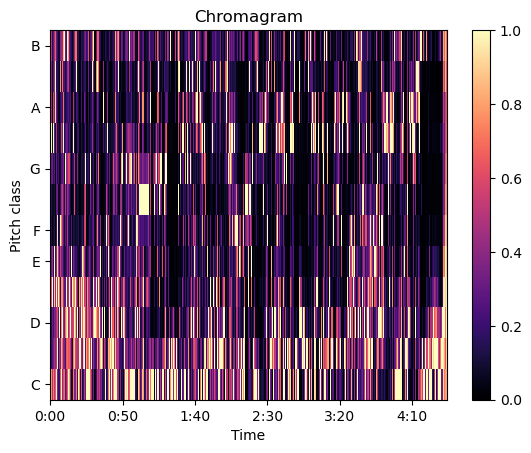

In [54]:
chroma = get_chroma_vector(example_file)
librosa.display.specshow(
    chroma, y_axis="chroma", fmax=10000, x_axis="time", vmin=0, vmax=1
)
# plt.title("Chroma Spectrogram")
# plt.colorbar(format="%+2.0f dB");

plt.title("Chromagram")
plt.colorbar()
# plt.figure(figsize=(20, 8))
# plt.title("Stairway To Heaven: Chroma Spectrogram")
# librosa.display.specshow(
#     chroma,
#     x_axis="s",
#     y_axis="chroma",
# );
# plt.imshow(chroma, interpolation='nearest', aspect='auto')
# plt.title('Chroma Vector - Rigoletto  Act 2 Cortigiani, vil razza dannata...Ebben piango by LSO')
# plt.show()

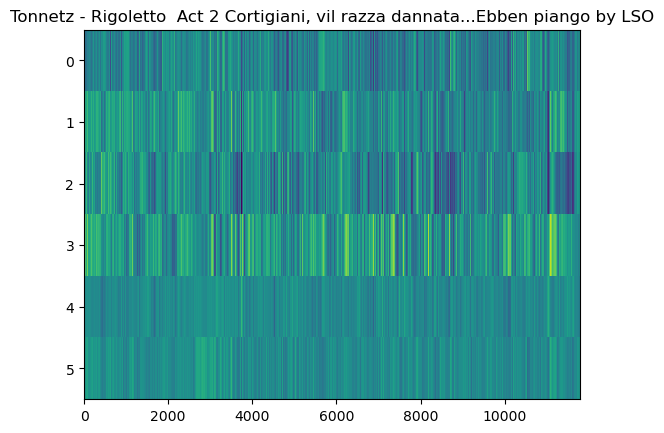

In [123]:
tntz = get_tonnetz(example_file)
plt.imshow(tntz , interpolation='nearest', aspect='auto')
plt.title('Tonnetz - Rigoletto  Act 2 Cortigiani, vil razza dannata...Ebben piango by LSO')
plt.show()

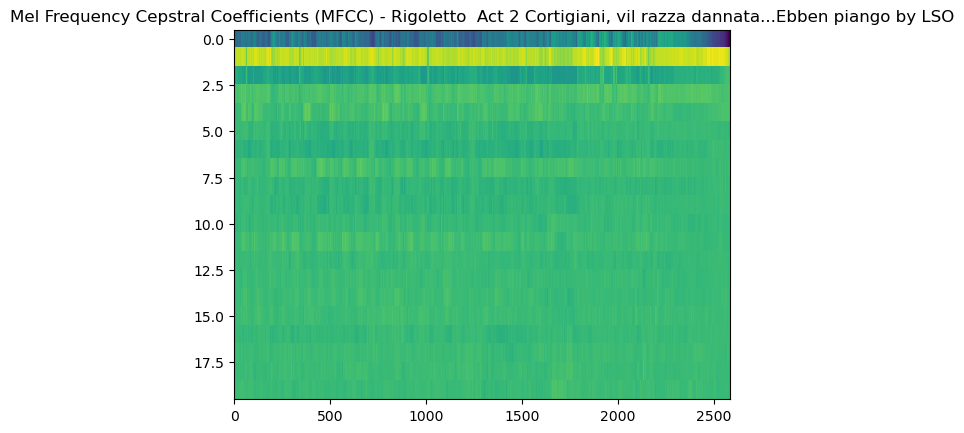

In [124]:
mfcc = get_mfcc(example_file)
plt.imshow(mfcc , interpolation='nearest', aspect='auto')
plt.title('Mel Frequency Cepstral Coefficients (MFCC) - Rigoletto  Act 2 Cortigiani, vil razza dannata...Ebben piango by LSO')
plt.show()

[Back to Table of Contents](#toc)

## Vectorizing Data <a class="anchor" id="vectorizing_data"></a>

The code used to vectorize the `.mp3` files is found below. First it uses a glob object from the `pathlib` library to recursively find all of the mp3s that successfully downloaded. Note that during this process two of the more than 11,000 mp3s did not download correctly from the downloader code and produced a file that could not be parsed. These files had to subsequently be deleted in order to prevent the code from halting due to errors. There is also a list created from the mp3s that have already been converted. This allows the function to have a resume functionality similar to the downloader which was implemented since it was not known initially how computationally intensive this process would be. Initially, all of the vectorized DataFrames were held in memory and concatenated at once. However, this process began to slow down over time and it was decided instead to write out each file individually and then concatenate everything back together once the vectorization had completed. 

Each song is converted into an 498-dimensional vector using the `get_feature` function defined above. It should also be noted that for the functions that require a time duration, each song is given a 10 second offset along with a 60 second audio sample. This helps to standardize the lengths of the mp3 files and also provides ample time to get the main melody or 'hook' of a song. Additionally, this method also normalizes for the volume of each of the songs which can vary depending on the recording. An example output from the vectoziation is shown below as reference. The number indicates the count for the individual mp3 along with the file path for the vectorized data.

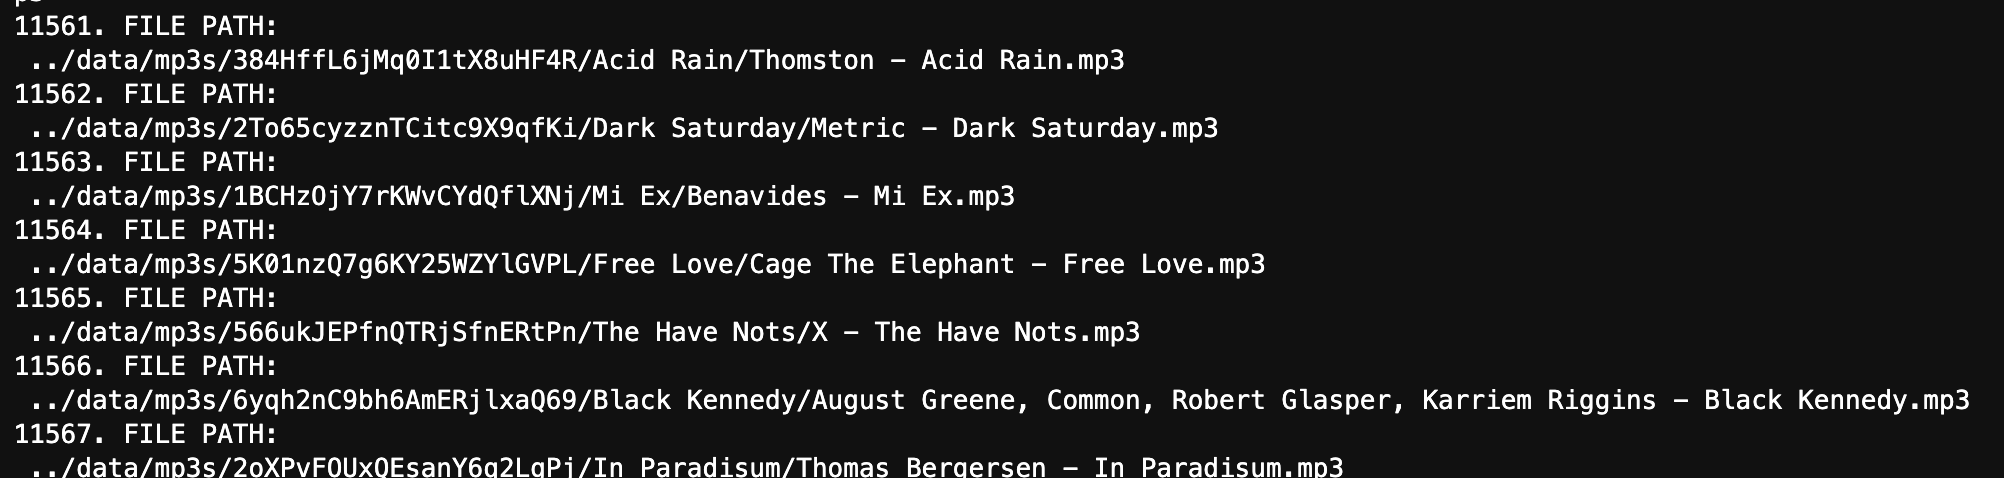

In [80]:
data_dir = Path('../data/mp3s/')
output_dir = Path('../data/vectorized_mp3s/')
path_glob = data_dir.rglob('*.mp3')
file_paths = []
for file_path in path_glob:
    file_paths.append(file_path) # creates a list for repeated iteration
    # if this is not done, the .rglob command above has to be repeated to regenerate iterator
len(file_paths) # number of mp3s in directory

11573

In [83]:
data_dir = Path('../data/mp3s/')
output_dir = Path('../data/vectorized_mp3s/')
downloaded_path_glob = data_dir.rglob('*.mp3')
output_path_glob = output_dir.rglob('*.parquet')
count = 1
file_paths = [file_path for file_path in downloaded_path_glob]
print('Number of MP3 Files: ', len(file_paths),'\n')
vectorized_track_ids = [file_path.stem for file_path in output_path_glob]
for file_path in file_paths:
    print(f'{count}. FILE PATH: \n', f'{file_path}')
    path_split = str(file_path).split('/')
    track_id = path_split[3]
    if (len(vectorized_track_ids)>0) & (track_id in vectorized_track_ids):
        print(f'{track_id} has already been vectorized...skipping...')
        count+=1
    else:
        track = get_feature(file_path)
        vectorized_df = pd.DataFrame(track).T
        vectorized_df['track_id'] = track_id
        vectorized_df = vectorized_df.set_index(vectorized_df.track_id).drop(columns = 'track_id')
        vectorized_df.columns = vectorized_df.columns.astype(str)
        vectorized_df.to_parquet(f"../data/vectorized_mp3s/{track_id}.parquet")
        count+=1

Number of MP3 Files:  11573 

1. FILE PATH: 
 ../data/mp3s/1ZB2qWsheGabSEYvBYxjKn/Take on Me/Weezer - Take on Me.mp3
1ZB2qWsheGabSEYvBYxjKn has already been vectorized...skipping...
2. FILE PATH: 
 ../data/mp3s/5V9H9J5GcUGY5ig029g5OU/Shkleepy/Manwolves - Shkleepy.mp3
5V9H9J5GcUGY5ig029g5OU has already been vectorized...skipping...
3. FILE PATH: 
 ../data/mp3s/34FsCOAQ0U99vAh3uoiLmm/Bandana (feat. Young Buck)/Dirty Audio, BL3R, Young Buck - Bandana (feat. Young Buck).mp3
34FsCOAQ0U99vAh3uoiLmm has already been vectorized...skipping...
4. FILE PATH: 
 ../data/mp3s/25mldAmMHYzXhDXCxTpTHy/Chloroform/Phoenix - Chloroform.mp3
25mldAmMHYzXhDXCxTpTHy has already been vectorized...skipping...
5. FILE PATH: 
 ../data/mp3s/1YaOBTTdptDf4vYKpFy56T/Mawaranai Toe Shoes/majiko - Mawaranai Toe Shoes.mp3
1YaOBTTdptDf4vYKpFy56T has already been vectorized...skipping...
6. FILE PATH: 
 ../data/mp3s/2RbDFTlqdIdiZwO4GaTxi2/moonwalking/Good Scott - moonwalking.mp3
2RbDFTlqdIdiZwO4GaTxi2 has already been vect

In [32]:
# Code here is presented for demonstration purposes much like the download code above
# vectorized_data_path = Path('../data/vectorized_mp3s/')
# path_glob = vectorized_data_path.rglob('*.parquet')
# dataframes= []
# for file_path in path_glob:
#     tmp = pd.read_parquet(f'{file_path}')
#     dataframes.append(tmp)
# vectorized_df = pd.concat(dataframes)

In [ ]:
vectorized_df.shape

In [ ]:
output_file_date = datetime.now().strftime("%Y%m%d") # time stamps the file with the reverse of the date
vectorized_df.to_parquet(f'../data/{output_file_date}_complete_vectorized_data.parquet')

[Back to Table of Contents](#toc)

## Pairwise Cosine Similarity <a class="anchor" id="pairwise_cosine_similarity"></a>

Once the code above generates a complete file containing all of the vectorized mp3s, the file is read in and a pairwise cosine similarity is run using the `pairwise` function from the `sklearn.metrics` library. This array is then sorted in order from most similar to least similar. A vector is then selected from this array and a list is created from the sorted vector. Next, the sorted vector is passed into the vectorized data to extract the tracks that are most similar to the track being asked for by the user. The list is returned in the order they were ranked and the summary statistics are obtained using the `describe` function. This set of tracks can then be used to create a playlist within Spotify.

In [75]:
vectorized_df = pd.read_parquet("../data/20230809_complete_vectorized_data.parquet")

In [76]:
vectorized_df.shape

(11571, 498)

In [77]:
vectorized_df.head()

0    1    2    3    4    5    6    7    8    9   10  \
track_id                                                                        
6DQzmTJnaZw4A9IynCGfrM 0.39 0.35 0.48 0.60 0.39 0.31 0.30 0.43 0.40 0.39 0.56   
1Bk00Y8bvqKHzUTDfEH2RH 0.36 0.37 0.54 0.45 0.49 0.36 0.38 0.37 0.45 0.55 0.42   
7x8MCsillTMQGAStE4dmW8 0.33 0.51 0.29 0.36 0.25 0.38 0.45 0.31 0.46 0.30 0.39   
11uz9XML4cezgIT4LO9Zq7 0.43 0.33 0.43 0.31 0.27 0.35 0.48 0.38 0.40 0.49 0.56   
63eqAbSLuqUQiT8wDOMWLF 0.45 0.31 0.37 0.40 0.27 0.35 0.31 0.39 0.40 0.32 0.36   

                         11   12   13   14   15   16   17   18   19   20   21  \
track_id                                                                        
6DQzmTJnaZw4A9IynCGfrM 0.36 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
1Bk00Y8bvqKHzUTDfEH2RH 0.48 0.01 0.00 0.00 0.01 0.01 0.01 0.00 0.00 0.01 0.01   
7x8MCsillTMQGAStE4dmW8 0.31 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
11uz9XML4cezgIT4LO9Zq7 0.78 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
63eqAbSLuqUQiT8wDOMWLF 0.34 0.00 0.00 0.00 0.01 0.00 0.01 0.01 0.01 0.00 0.00   

                         22   23   24   25   26   27   28   29   30   31   32  \
track_id                                                                        
6DQzmTJnaZw4A9IynCGfrM 0.00 0.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00   
1Bk00Y8bvqKHzUTDfEH2RH 0.01 0.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00   
7x8MCsillTMQGAStE4dmW8 0.00 0.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00   
11uz9XML4cezgIT4LO9Zq7 0.00 0.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00   
63eqAbSLuqUQiT8wDOMWLF 0.00 0.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00   

                         33   34   35     36     37     38     39     40  \
track_id                                                                   
6DQzmTJnaZw4A9IynCGfrM 1.00 1.00 1.00   2.61  92.35 249.16 149.52 114.11   
1Bk00Y8bvqKHzUTDfEH2RH 1.00 1.00 1.00   4.20  33.12  77.22 108.47 117.57   
7x8MCsillTMQGAStE4dmW8 1.00 1.00 1.00 123.10 357.55 163.28  24.27  38.85   
11uz9XML4cezgIT4LO9Zq7 1.00 1.00 1.00   0.23  49.79  32.56  10.21  34.48   
63eqAbSLuqUQiT8wDOMWLF 1.00 1.00 1.00   0.03   0.96   2.75   3.16   1.21   

                           41    42    43    44    45    46    47    48    49  \
track_id                                                                        
6DQzmTJnaZw4A9IynCGfrM 101.26 39.42 54.09 68.31 38.08 33.50 66.19 24.96 13.64   
1Bk00Y8bvqKHzUTDfEH2RH  95.99 83.92 57.37 41.07 35.75 25.14 30.33 48.36 11.52   
7x8MCsillTMQGAStE4dmW8  29.56 62.96 63.67 36.98 28.84 32.20 10.96  9.98 25.56   
11uz9XML4cezgIT4LO9Zq7   1.99 25.13  7.36 25.62 23.60  1.17  9.07  4.55 40.66   
63eqAbSLuqUQiT8wDOMWLF   0.40  0.55  0.77  1.14  2.24  1.18  1.17  1.30  2.19   

                          50    51    52    53    54    55    56    57    58  \
track_id                                                                       
6DQzmTJnaZw4A9IynCGfrM 12.72 16.20 10.23 20.15  9.23 19.52 19.78 15.80 26.43   
1Bk00Y8bvqKHzUTDfEH2RH 13.99 14.43 12.81  7.80 19.01 11.85  3.74  5.82 10.51   
7x8MCsillTMQGAStE4dmW8 26.48 30.31 15.91 21.12 16.61  8.19 31.31 33.00  9.19   
11uz9XML4cezgIT4LO9Zq7 13.70  1.14  8.01  9.57 44.00  7.45  2.77 15.06 25.71   
63eqAbSLuqUQiT8wDOMWLF  2.59  3.06  1.57  1.57  1.70  3.00  2.28  1.57  3.26   

                          59    60    61    62    63    64    65    66    67  \
track_id                                                                       
6DQzmTJnaZw4A9IynCGfrM 56.37 39.87 19.13 32.25 33.96 17.69 29.47 23.82 17.68   
1Bk00Y8bvqKHzUTDfEH2RH  3.33  2.41  2.79  3.50  6.79 12.00  5.53  4.81  8.72   
7x8MCsillTMQGAStE4dmW8 32.29 14.43  4.50  7.53 11.12 14.80  3.42  3.78 30.10   
11uz9XML4cezgIT4LO9Zq7  1.83  0.38  0.18  0.13  1.02  0.95  0.10  0.14  0.18   
63eqAbSLuqUQiT8wDOMWLF  3.47  1.86  0.87  1.47  1.34  1.17  1.45  2.57  2.69   

                          68    69    70    71    72    73   74    75    76  \
track_id            

In [78]:
pairwise_similarity = pairwise.cosine_similarity(vectorized_df, dense_output=True)
pairwise_similarity
# creates the pairwise array

array([[1.        , 0.54363264, 0.78515052, ..., 0.56113011, 0.56777812,
        0.47859063],
       [0.54363264, 1.        , 0.73388236, ..., 0.60629795, 0.63824798,
        0.75671194],
       [0.78515052, 0.73388236, 1.        , ..., 0.78544811, 0.81991725,
        0.56773694],
       ...,
       [0.56113011, 0.60629795, 0.78544811, ..., 1.        , 0.95658432,
        0.30158498],
       [0.56777812, 0.63824798, 0.81991725, ..., 0.95658432, 1.        ,
        0.34333049],
       [0.47859063, 0.75671194, 0.56773694, ..., 0.30158498, 0.34333049,
        1.        ]])

In [79]:
pairwise_similarity_sorted = np.argsort(pairwise_similarity)[:, ::-1]
# sorts the pairwise array so that similar tracks appear closer to the left

In [80]:
pairwise_similarity_sorted.shape

(11571, 11571)

In [81]:
pairwise_similarity_sorted

array([[    0,  2451,  2907, ...,  2292,  6239,  2240],
       [    1,  8889, 11241, ...,  2292,  5445,  2240],
       [    2,  6733,  1095, ...,  2240,  2692,  6239],
       ...,
       [11568,  1828,  4583, ...,  9295,  2292,  6239],
       [11569, 10011,  8999, ...,  2692,   375,  6239],
       [11570,  6846, 10994, ...,  9811,  7212,  6678]])

In [86]:
vec = list(pairwise_similarity_sorted[0, 0:11])  # selects vector from array
vec

[0, 2451, 2907, 5557, 11436, 4479, 1214, 2144, 8357, 3311, 11454]

In [87]:
pairwise_similarity[0, vec]  # similarity for first match

array([1.        , 0.91143821, 0.90442925, 0.90343174, 0.90339702,
       0.90006026, 0.90002909, 0.89924396, 0.89745566, 0.89403305,
       0.89280331])

In [89]:
np.mean(pairwise_similarity[0, vec])

0.9096655955649272

In [92]:
recommended_track_ids = list(vectorized_df.iloc[vec,:].index) 
# passes the vector into the original DataFrame and extracts the
# track IDs from the index
recommended_track_ids

['6DQzmTJnaZw4A9IynCGfrM',
 '0iPAXRIiRq1vSHbEnjSnZ6',
 '13TbXtmTJ17OuFqW9y7eTw',
 '0WXb6fBOqbr3GoRKhAz4us',
 '3uSeT5T2pOEx5fTdYFJasm',
 '4d9GVZP50tSxTfBvHEHUPx']

In [94]:
kaggle_df['track_id'] = kaggle_df['track_id'].astype("category")
kaggle_df['track_id'] = kaggle_df.track_id.cat.set_categories(recommended_track_ids) 
# sets this as a category and provides a hierarchy
# this preserves the order of the tracks from the list

In [95]:
track_recommendations = kaggle_df.copy(deep=True).sort_values(["track_id"]).head(6) # sorts heirarchy
track_recommendations

genre         artist_name                       track_name  \
53452     Blues  The Detroit Cobras                   Shout Bamalama   
32115     Anime                 luz  Queen of Heart - Sister Edition   
187364      Ska              Rancid     Something In The World Today   
31113     Anime                FLOW           Howling - Instrumental   
216175  Country       Rascal Flatts                         Why Wait   
15171     Dance               Lizzo                         Water Me   

                      track_id  popularity  acousticness  danceability  \
53452   6DQzmTJnaZw4A9IynCGfrM          26          0.03          0.29   
32115   0iPAXRIiRq1vSHbEnjSnZ6          21          0.00          0.52   
187364  13TbXtmTJ17OuFqW9y7eTw          26          0.01          0.31   
31113   0WXb6fBOqbr3GoRKhAz4us          26          0.00          0.49   
216175  3uSeT5T2pOEx5fTdYFJasm          44          0.12          0.61   
15171   4d9GVZP50tSxTfBvHEHUPx          61          0.03          0.67   

        duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
53452        121427    0.92              0.36  D#      0.38     -3.21  Major   
32115        213070    0.89              0.00  A#      0.32     -5.08  Minor   
187364       153600    0.99              0.00   G      0.25     -2.16  Major   
31113        260333    0.91              0.85  A#      0.09     -3.38  Minor   
216175       224840    0.77              0.00   D      0.10     -4.92  Major   
15171        185595    0.97              0.00  D#      0.18     -1.99  Minor   

        speechiness  tempo time_signature  valence  
53452          0.07 172.45          4-Apr     0.96  
32115          0.05 117.60          4-Apr     0.56  
187364         0.10 167.12          4-Apr     0.30  
31113          0.04  99.99          4-Apr     0.52  
216175         0.04 122.02          4-Apr     0.55  
15171          0.18 113.05          4-Apr     0.77

In [96]:
track_recommendations.describe()
# summary statistics for recommendations

popularity  acousticness  danceability  duration_ms  energy  \
count        6.00          6.00          6.00         6.00    6.00   
mean        34.00          0.03          0.48   193,144.17    0.91   
std         15.43          0.05          0.15    50,358.89    0.08   
min         21.00          0.00          0.29   121,427.00    0.77   
25%         26.00          0.00          0.36   161,598.75    0.90   
50%         26.00          0.02          0.50   199,332.50    0.91   
75%         39.50          0.03          0.59   221,897.50    0.95   
max         61.00          0.12          0.67   260,333.00    0.99   

       instrumentalness  liveness  loudness  speechiness  tempo  valence  
count              6.00      6.00      6.00         6.00   6.00     6.00  
mean               0.20      0.22     -3.46         0.08 132.04     0.61  
std                0.35      0.12      1.32         0.05  30.20     0.23  
min                0.00      0.09     -5.08         0.04  99.99     0.30  
25%                0.00      0.12     -4.53         0.04 114.18     0.53  
50%                0.00      0.22     -3.30         0.06 119.81     0.56  
75%                0.27      0.31     -2.42         0.09 155.84     0.72  
max                0.85      0.38     -1.99         0.18 172.45     0.96

[Back to Table of Contents](#toc)

## Creating Recommendation Playlist <a class="anchor" id="creating_playlist"></a>

In the final step, the Spotify API is queried to generate a playlist that contains the original track along with the top five matches in terms of similarity. It should be noted that to get this to work, a flask app was originally designed to allow for authentication of the scopes required for writing a playlist into the user's account. This code is used only once to generate those permissions and is presented below. However, it is commented out for the sake of brevity. Once the playlist is created using the parameters, the track IDs are passed in to populate the playlist which the user then has the ability to listen to from their personal Spotify account. It is also worth noting here, that due to difficulties in setting up the authorization code flow required for this step, ChatGPT was consulted in order to sketch out the original idea for how this process would work. Additionally, the video entitled "Spotify OAuth: Automating Discover Weekly Playlist - Full Tutorial" by the YouTuber Synsation (Github: katiagilligan888) was also used to help setup the authentication process.

* Github link: https://github.com/katiagilligan888/Spotify-Discover-Weekly
* Spotify OAuth: Automating Discover Weekly Playlist video link: https://www.youtube.com/watch?v=mBycigbJQzA

### Flask App for Authorization <a class="anchor" id="flask_app"></a>

In [110]:
 # THIS CODE WORKS -- However, I don't want to use a self-contained Flask app as it interrupts my flow
app = Flask(__name__)

sp_oauth = SpotifyOAuth(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    redirect_uri=REDIRECT_URI,
    scope=SCOPE,
    cache_path=".cache",
)

@app.route('/')
def index():
    return "Hello, this is a Flask app!"

@app.route('/login')
def login():
    auth_url = sp_oauth.get_authorize_url()
    return redirect(auth_url)

@app.route('/callback')
def callback():
    code = request.args['code']
    token_info = sp_oauth.get_access_token(code)
    access_token = token_info['access_token']

    sp = spotipy.Spotify(auth=access_token)

    username = sp.me()['id']
    playlist_name = 'My Blank Playlist'

    playlist = sp.user_playlist_create(
        user=username,
        name=playlist_name,
        public=False
    )

    return f"Playlist '{playlist_name}' created by user '{username}'"

if __name__ == '__main__':
    app.run(port=5000)

[Back to Table of Contents](#toc)

### Playlist Creation <a class="anchor" id="playlist_creation"></a>

In [113]:
# Initialize SpotifyOAuth
sp_oauth = SpotifyOAuth(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    redirect_uri=REDIRECT_URI,
    scope=SCOPE,
    cache_path=".cache",
    show_dialog=False
)

def main(recommended_track_ids: List):
    # Get cached token or start authorization process
    access_token_info = sp_oauth.get_cached_token()
    if access_token_info:
        access_token = access_token_info['access_token']
    else:
        print("Authorization required. Visit the following URL to authorize:")
        auth_url = sp_oauth.get_authorize_url()
        print(auth_url)
        return

    # Initialize spotipy with access token
    sp = spotipy.Spotify(auth=access_token)

    # Replace 'Your Username' with your Spotify username
    username = USERNAME
    playlist_name = f'Recommendation Playlist for Track {recommended_track_ids[0]}'
    playlist_description = f'These are the top five matches for track {recommended_track_ids[0]}'

    try:
        # Create a blank playlist
        playlist = sp.user_playlist_create(
            user=username,
            name=playlist_name,
            description = playlist_description,
            public=False
        )
        print(f"Playlist '{playlist_name}' was created")
    except spotipy.SpotifyException as e:
        print(f"An error occurred: {e}")

# List of track IDs (URIs) to add to the playlist
    prefix = 'spotify:track:'
    track_uris = list(prefix+x for x in recommended_track_ids)
    
    # track_ids = [
    #     'spotify:track:track_id_1',
    #     'spotify:track:track_id_2',
    #     # Add more track IDs here
    # ]

    # Add tracks to the playlist
    sp.user_playlist_add_tracks(user=username, playlist_id=playlist['id'], tracks=track_uris)
    
if __name__ == '__main__':
    main(recommended_track_ids)

Playlist 'Recommendation Playlist for Track 6DQzmTJnaZw4A9IynCGfrM' was created


The output playlist then looks like the screenshot below:
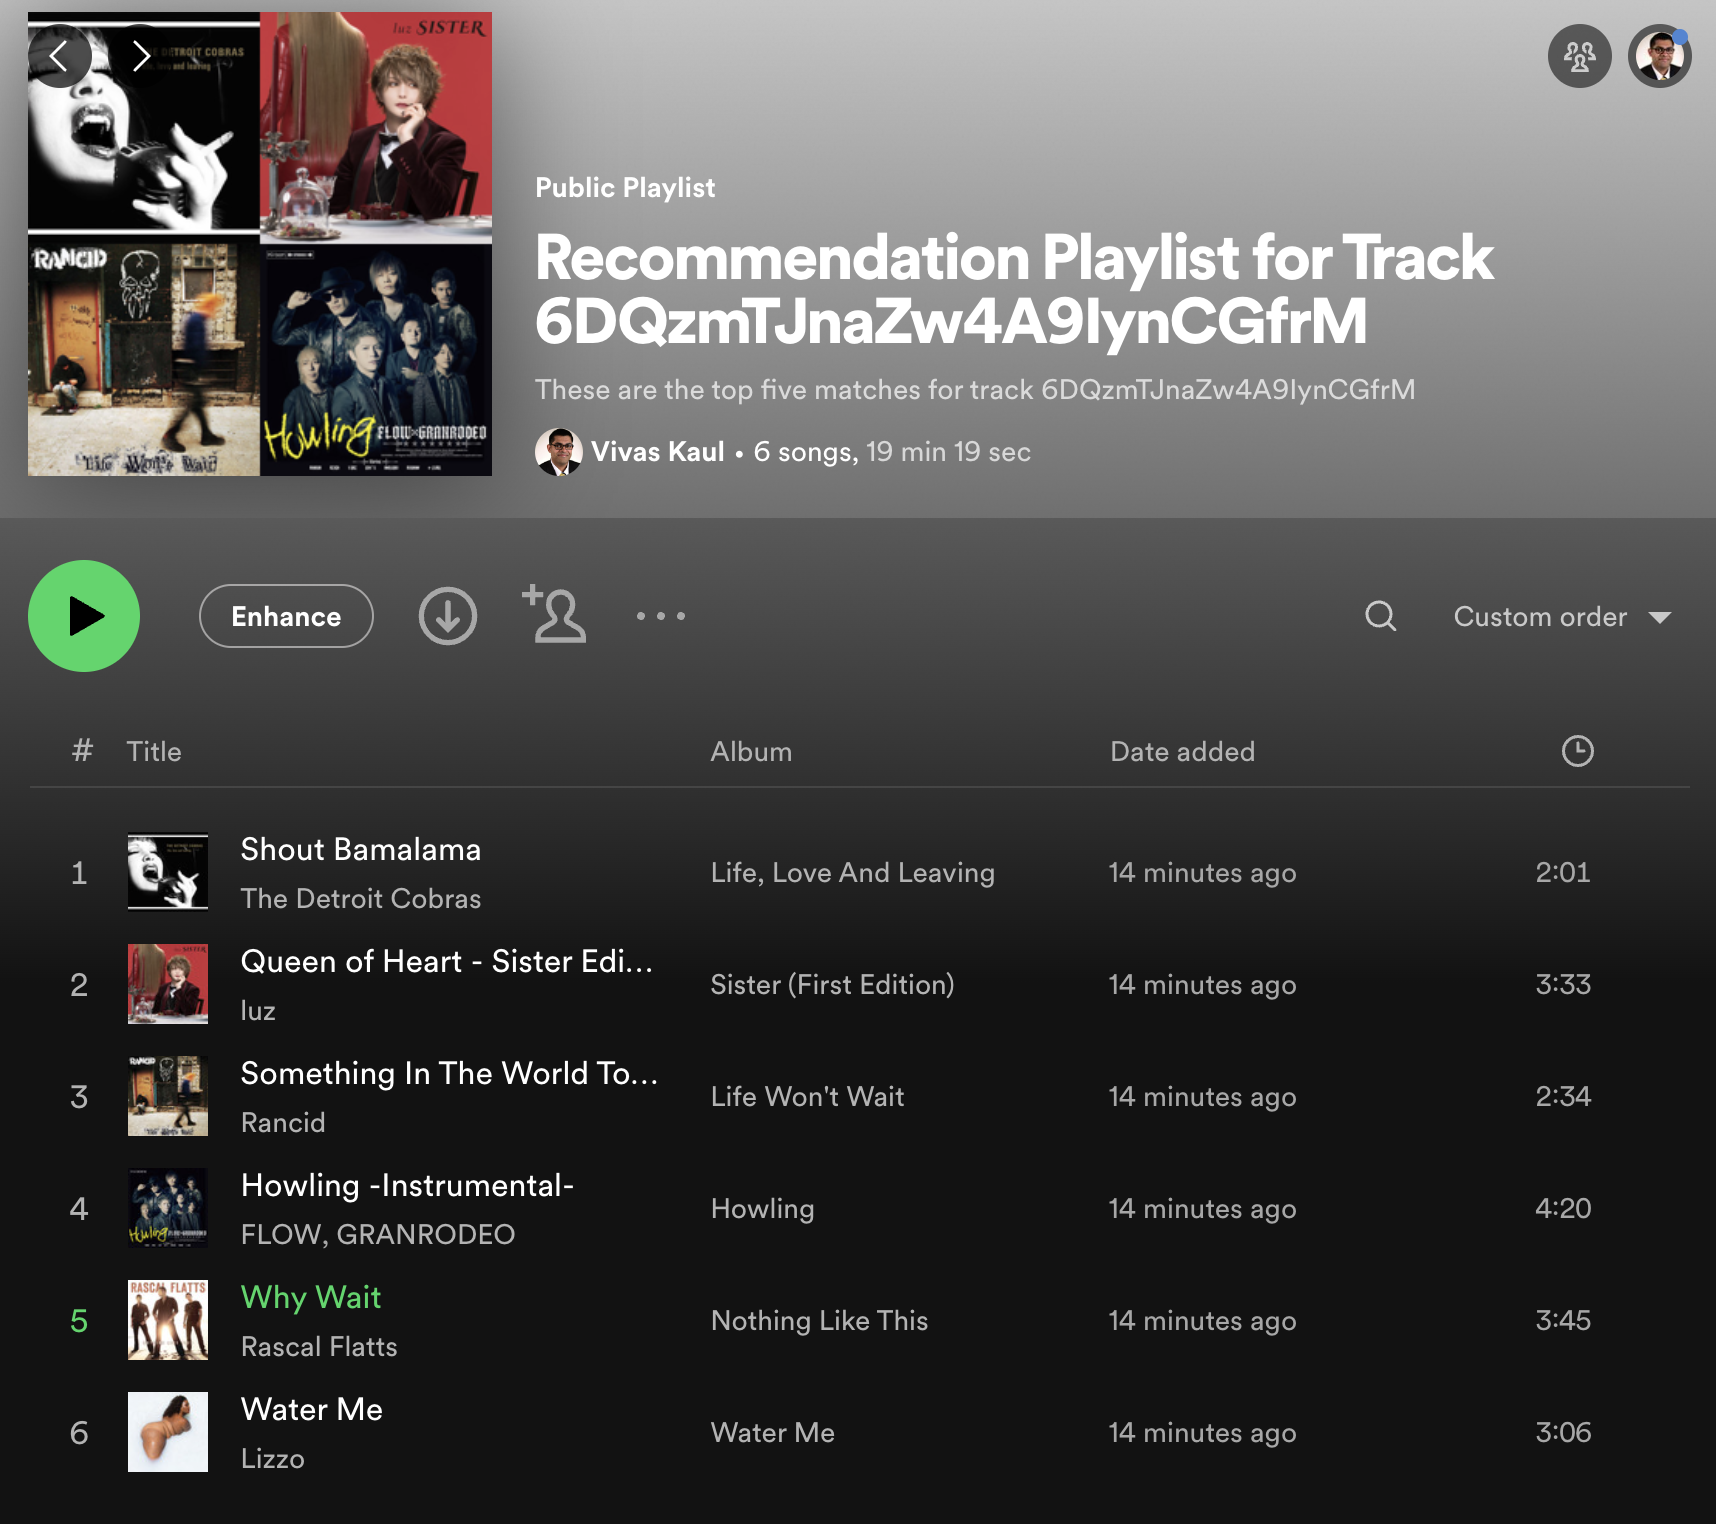

[Back to Table of Contents](#toc)

## Conclusion <a class="anchor" id="conclusion"></a>
In conclusion, Sprint 2 saw the development of several key strides forward in the creation of a model. First it saw the acquisition and encoding of a training set of more than 11,000 mp3s. This data was then vectorized into a 498 dimension vector and used to produce a pairwise similarity. Finally, the results of similarity calculation were then used to produce a playlist of songs and provided to the user for their consideration. In terms of future plans, for Sprint 3 the focus will be on creating a more robust model using a convolutional neural network (CNN) and also further defining the success metric for the recommendations that are provided. One possibility would be to compare the results generated with the recommendation engine from Spotify itself. Another possibility might be to serve this code to some of the other students from within the cohort and get their feedback as to the recommendations provided by the engine.

[Back to Table of Contents](#toc)